# Simple Cycle Example with BMS and Random Sampling
The aim of this example notebook is to use the AutoRA `Cycle` to recover a ground truth theory from some noisy data using BSM.

In [130]:
import matplotlib.pyplot as plt
import numpy as np

from autora.cycle import Cycle, cycle_specified_score, plot_cycle_score, plot_results_panel_2d
from sklearn.metrics import r2_score
from autora.experimentalist.sampler import random_sampler, nearest_values_sampler
from autora.experimentalist.pipeline import make_pipeline
from autora.variable import VariableCollection, Variable
from autora.skl.bms import BMSRegressor

The ground truth we are trying to recover will be an oscillating function with a parabolic component.

In [131]:
def ground_truth(xs):
    oscillating_component = np.sin((4. * xs) - 3.)
    parabolic_component =  (-0.1 * xs ** 2.) + (2.5 * xs) + 1.
    ys = oscillating_component + parabolic_component
    return ys

The space of allowed x values is reals between -10 and 10 inclusive. We discretize them as we don't currently have a sampler which can sample from the uniform distribution.

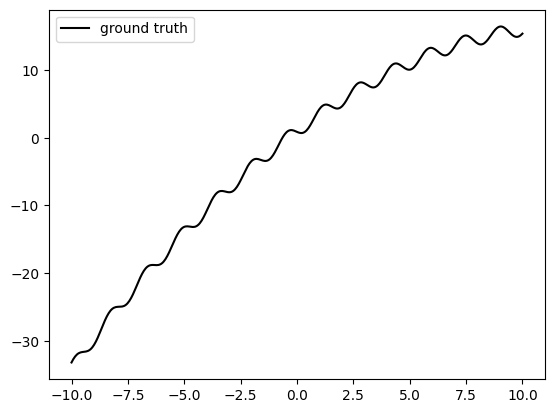

In [132]:
study_metadata = VariableCollection(
   independent_variables=[Variable(name="x1", allowed_values=np.linspace(-10, 10, 500))],
   dependent_variables=[Variable(name="y")],
   )

plt.plot(study_metadata.independent_variables[0].allowed_values, ground_truth(study_metadata.independent_variables[0].allowed_values), c="black", label="ground truth")
plt.legend()

## Experiment Runner
We create a synthetic experiment that adds noise.

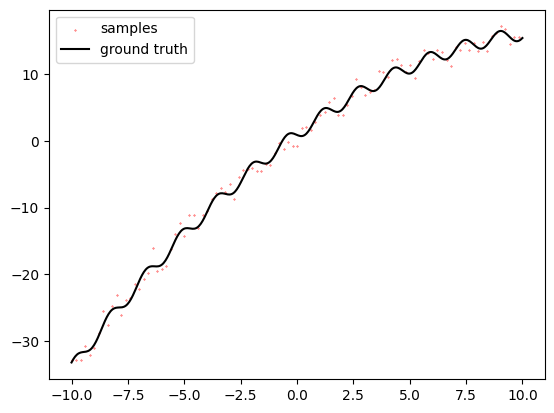

In [133]:
def get_example_synthetic_experiment_runner():
    rng = np.random.default_rng(seed=180)
    def runner(xs):
        return ground_truth(xs) + rng.normal(0, 1.0, xs.shape)
    return runner

example_synthetic_experiment_runner = get_example_synthetic_experiment_runner()

plt.scatter(study_metadata.independent_variables[0].allowed_values[::5,], example_synthetic_experiment_runner(study_metadata.independent_variables[0].allowed_values[::5,]), alpha=1, s=0.1, c='r', label="samples")
plt.plot(study_metadata.independent_variables[0].allowed_values, ground_truth(study_metadata.independent_variables[0].allowed_values), c="black", label="ground truth")
plt.legend()

## Random Sampler Experimentalist

In [134]:
n_cycles = 5
n_observations_per_cycle = 50

random_experimentalist = make_pipeline(
    [study_metadata.independent_variables[0].allowed_values, random_sampler],
    params={"random_sampler": {"n": n_observations_per_cycle}}
)

## Test Set
To create a test set, we will randomly select conditions for 1/3 of the total observations. This will be calculated as 1/3 of the all observations over the cycles + the test set. Note that the similar conditions in the test set may be sampled during the cycle; added noise to the

In [135]:
test_split = .33
n_test = int(np.round((test_split * (n_cycles * n_observations_per_cycle)) / (1-test_split)))
test_set_generator = make_pipeline(
    [study_metadata.independent_variables[0].allowed_values, random_sampler],
    params={"random_sampler": {"n": n_test}}
)
X_test = np.array(test_set_generator.run()).reshape(-1,1)
y_test = ground_truth(X_test)

print(f'Number of test samples: {n_test}')

Number of test samples: 123


## Test Set
To create the test set we will use the ground truth.

In [136]:
X_test = study_metadata.independent_variables[0].allowed_values.reshape(-1,1)
y_test = ground_truth(X_test)

We use a common BMS regressor with a common parametrization.

In [137]:
## Theorist
bms_theorist = BMSRegressor(epochs=1000)

random_experimentalist_cycle = Cycle(
    metadata=study_metadata,
    theorist=bms_theorist,
    experimentalist=random_experimentalist,
    experiment_runner=example_synthetic_experiment_runner
)

random_experimentalist_cycle.run(n_cycles)

INFO:autora.skl.bms:BMS fitting started
<lambdifygenerated-434016>:2: RuntimeWarning: invalid value encountered in power
  return X0**X0
<lambdifygenerated-434017>:2: RuntimeWarning: invalid value encountered in power
  return X0**X0
<lambdifygenerated-434018>:2: RuntimeWarning: invalid value encountered in power
  return X0**X0
<lambdifygenerated-434019>:2: RuntimeWarning: invalid value encountered in power
  return X0**_a0_
/Users/gdang2/Library/Caches/pypoetry/virtualenvs/autora-X9HhP-Rm-py3.8/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<lambdifygenerated-434020>:2: RuntimeWarning: invalid value encountered in power
  return X0**_a0_
<lambdifygenerated-434021>:2: RuntimeWarning: invalid value encountered in power
  return X0**_a0_
INFO:autora.theorist.bms.utils:Finish iteration 0
INFO:autora.theorist.bms.utils:Finish iteration

In [138]:
scores = cycle_specified_score(r2_score, random_experimentalist_cycle, X_test, y_test)
print(scores)

[0.9821033471342709, 0.993688775999343, 0.9948437576491572, 0.9958487515659598, 0.995915972839974]


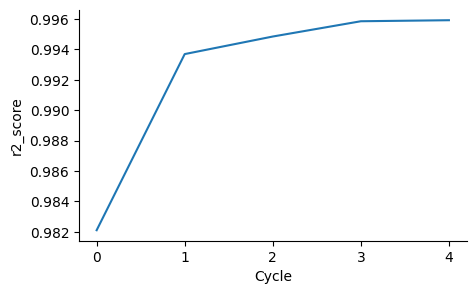

In [139]:
plot_cycle_score(random_experimentalist_cycle, X_test, y_test,
                 scorer=r2_score,
                 figsize=(5,3));


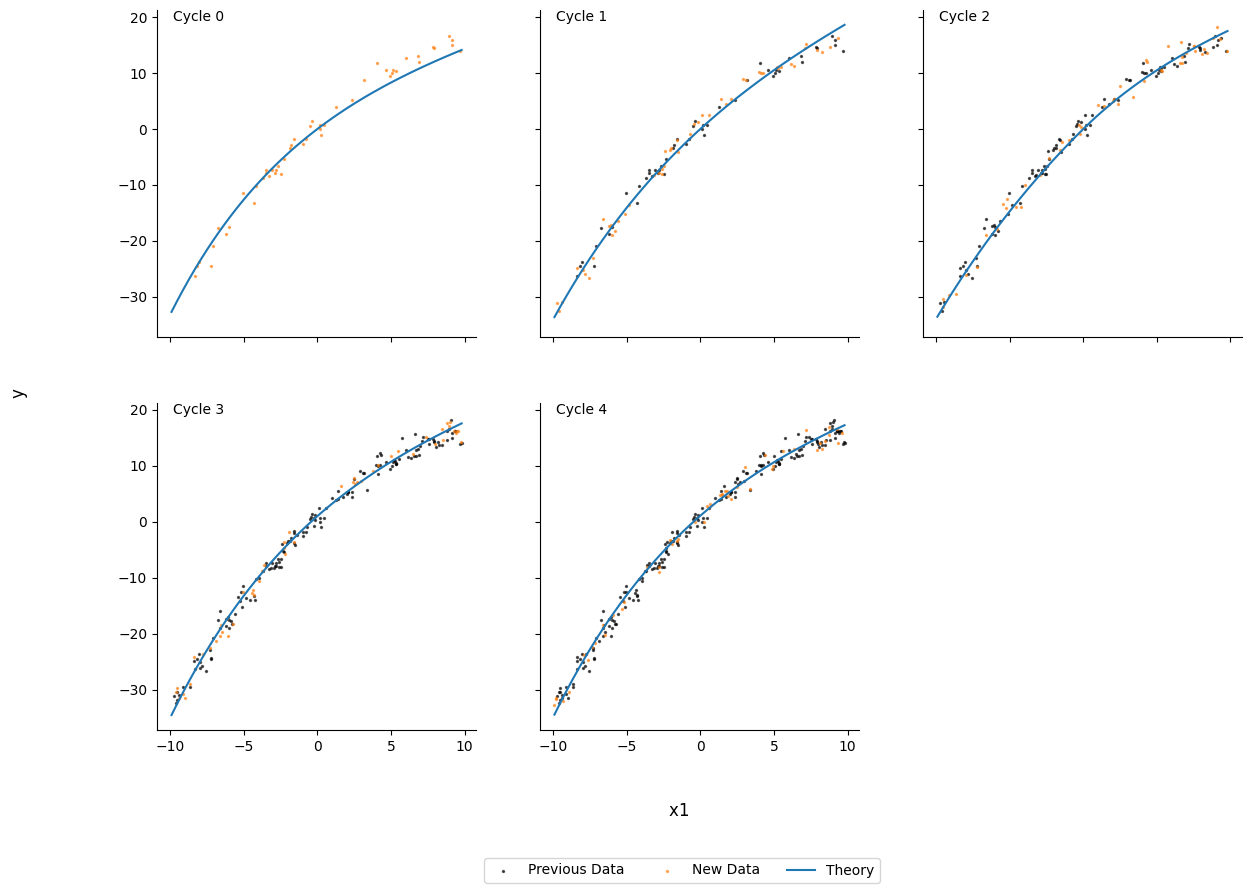

In [140]:
plot_results_panel_2d(random_experimentalist_cycle,
                      wrap=3,
                      subplot_kw=dict(figsize=(14,10))
                      );


INFO:autora.skl.bms:BMS fitting started
<lambdifygenerated-575175>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(_a0_)
<lambdifygenerated-575187>:2: RuntimeWarning: invalid value encountered in double_scalars
  return _a0_**_a0_
<lambdifygenerated-575205>:2: RuntimeWarning: invalid value encountered in log
  return log(X0)
<lambdifygenerated-575206>:2: RuntimeWarning: invalid value encountered in log
  return log(X0)
<lambdifygenerated-575207>:2: RuntimeWarning: invalid value encountered in log
  return log(X0)
INFO:autora.theorist.bms.utils:Finish iteration 0
<lambdifygenerated-575239>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(X0)
<lambdifygenerated-575240>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(X0)
<lambdifygenerated-575241>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(X0)
<lambdifygenerated-575244>:2: RuntimeWarning: invalid value encountered in power
  return X0**X0
<lambdifygenerated-57

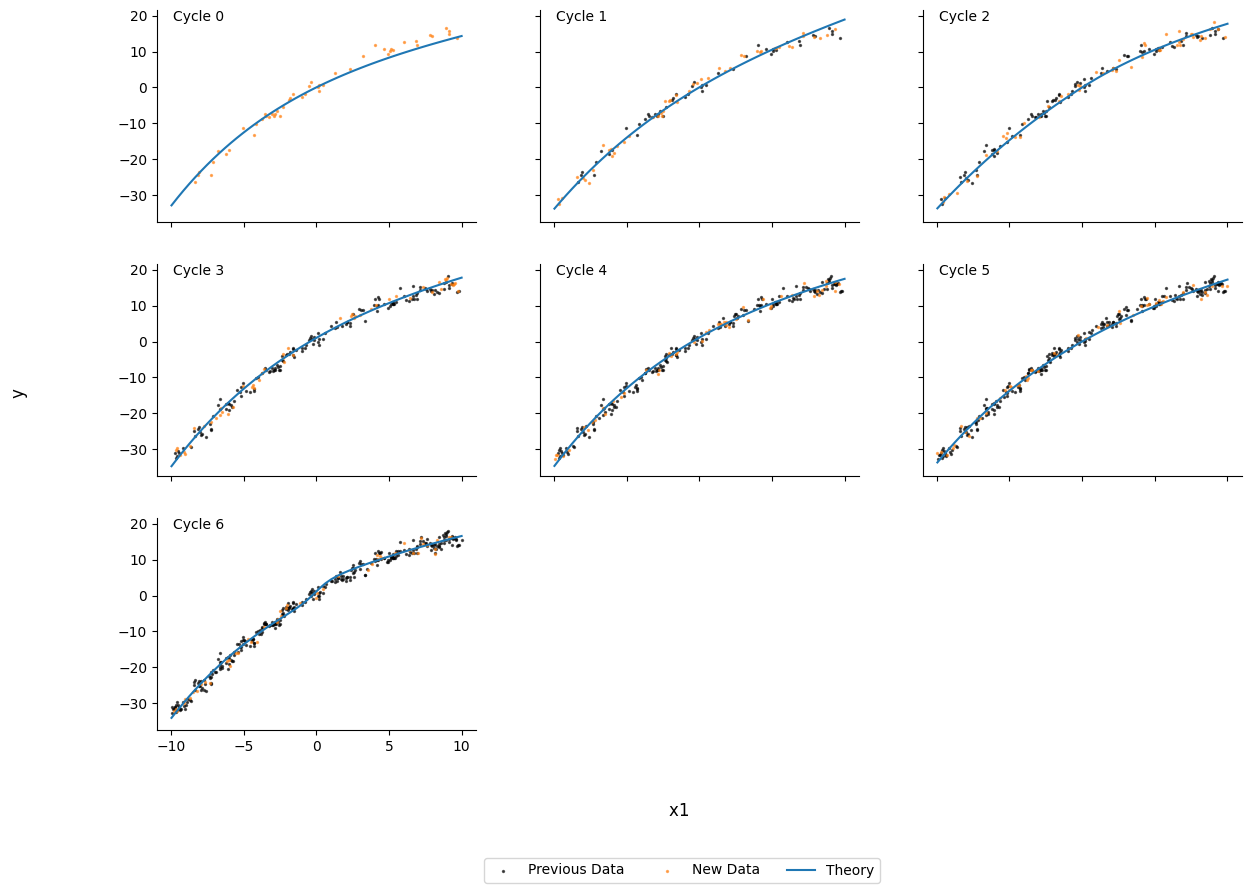

In [141]:
random_experimentalist_cycle.run(2)
plot_results_panel_2d(random_experimentalist_cycle,
                      wrap=3,
                      subplot_kw=dict(figsize=(14,10))
                      );
